# 3D displacement from asc/desc InSAR & azimuth offset

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from scipy import linalg
from skimage.transform import resize
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut
from mintpy.asc_desc2horz_vert import get_design_matrix4east_north_up
from mintpy.ifgram_inversion import skip_invalid_obs
from mintpy.cli import view, image_stitch, save_gdal
from mintpy.view import prep_slice, plot_slice
plt.rcParams.update({'font.size': 12})

S, N, W, E = 16.5, 24, 94, 98
ref_lat, ref_lon = 20 ,94.6

proj_dir = os.path.expanduser('/home/eedy/penguin/25EQ_myanmar/')
work_dir = os.path.join(proj_dir, 's1_3D_result')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# output
dis_enu_file = os.path.join(work_dir, 'defo3d/dis_enu.h5')
dis_enu_std_file = os.path.join(work_dir, 'defo3d/dis_enu_std.h5')

Go to directory: /home/eedy/penguin/25EQ_myanmar/s1_3D_result


## 1. Stitich adjcent tracks

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_RG/offRg.geo', '/home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_RG/offRg.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_RG/offRg.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_RG/offRg.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
average offset between two matrices in the common area: 0.02710228860393292
offset all pixel values in the 2nd matrix by 0.02710228860393292 
create output metadata and matrix in shape of (2700, 1440)
update LENGTH/WIDT

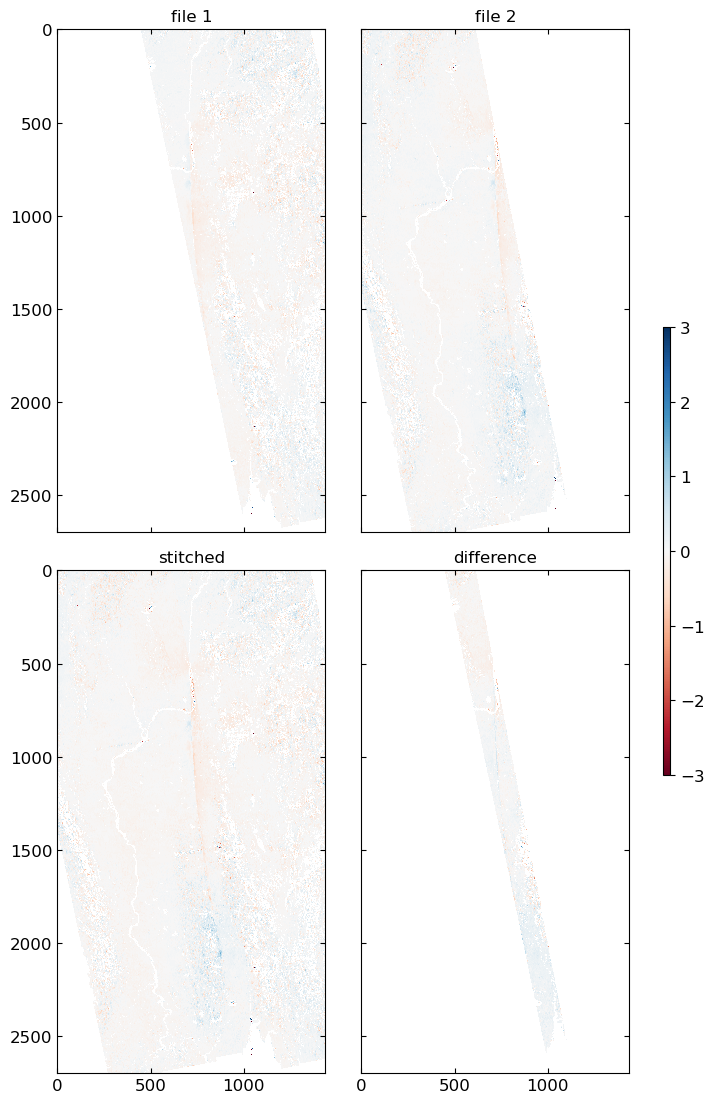

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_RG/offRgStd.geo', '/home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_RG/offRgStd.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_RG/offRgStd.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_RG/offRgStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
create output metadata and matrix in shape of (2700, 1440)
update LENGTH/WIDTH: 2700/1440
update Y/X_FIRST: 24.0/94.0
update REF_Y/X: 1080/1080
##################################################
write file: 

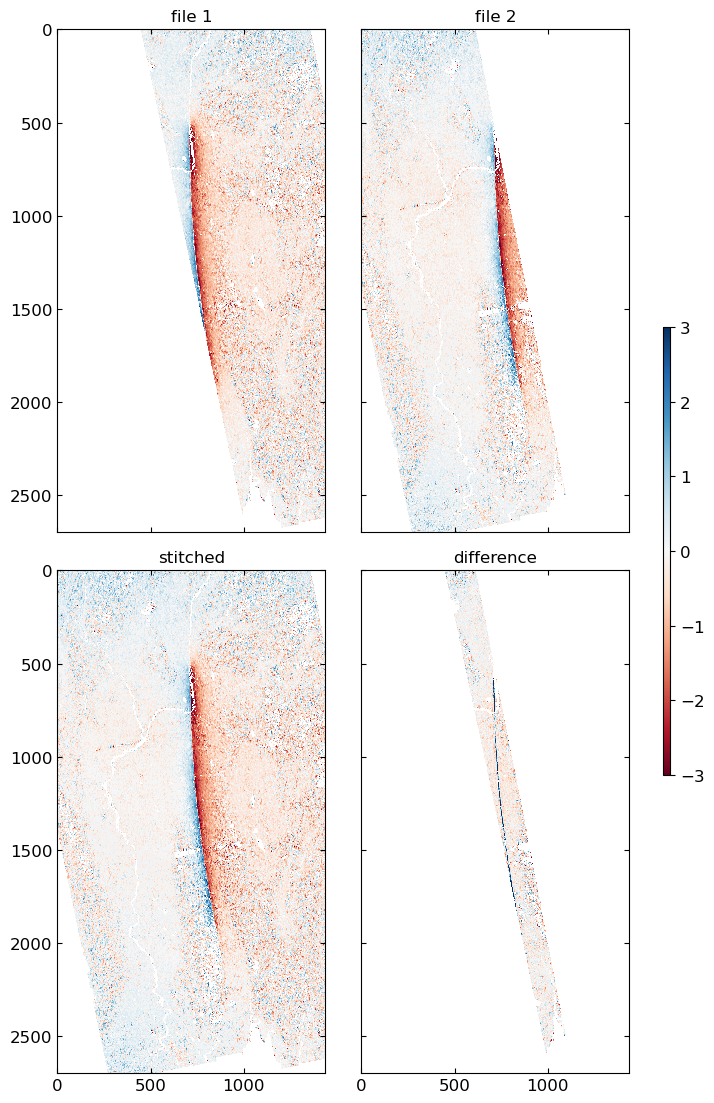

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_AZ/offAzStd.geo', '/home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_AZ/offAzStd.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_AZ/offAzStd.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_AZ/offAzStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
create output metadata and matrix in shape of (2700, 1440)
update LENGTH/WIDTH: 2700/1440
update Y/X_FIRST: 24.0/94.0
update REF_Y/X: 1098/1080
##################################################
write file: 

In [2]:
for suffix in ['RG', 'AZ']:
    dnames_in = [f's1_a070/20250322_20250403/merged/dense_v1/S1_A070_20250322_20250403_OFF_{suffix}',f's1_a143/20250327_20250408/merged/dense_v1/S1_A143_20250327_20250408_OFF_{suffix}']
    dname_out = f'data/s1_acs_{suffix}'
    if suffix == 'RG':
        fbases = ['offRg.geo', 'offRgStd.geo', 'enu.geo']
    else:
        fbases = ['offAz.geo', 'offAzStd.geo', 'enu.geo']
    opts = ['', '--no-offset', '--no-offset']
    for i, (fbase, opt) in enumerate(zip(fbases, opts)):
        fnames_in = [os.path.join(proj_dir, dname_in, fbase) for dname_in in dnames_in]
        fname_out = os.path.join(dname_out, fbase)
        cmd = ' '.join(x for x in fnames_in) + f' -o {fname_out} {opt} -c RdBu '
        cmd += ' -v -3 3 ' if i == 0 else ''
        image_stitch.main(cmd.split())

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_RG/offRg.geo', '/home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_RG/offRg.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_RG/offRg.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_RG/offRg.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
average offset between two matrices in the common area: 0.025022118134102087
offset all pixel values in the 2nd matrix by 0.025022118134102087 
create output metadata and matrix in shape of (2700, 1440)
update L

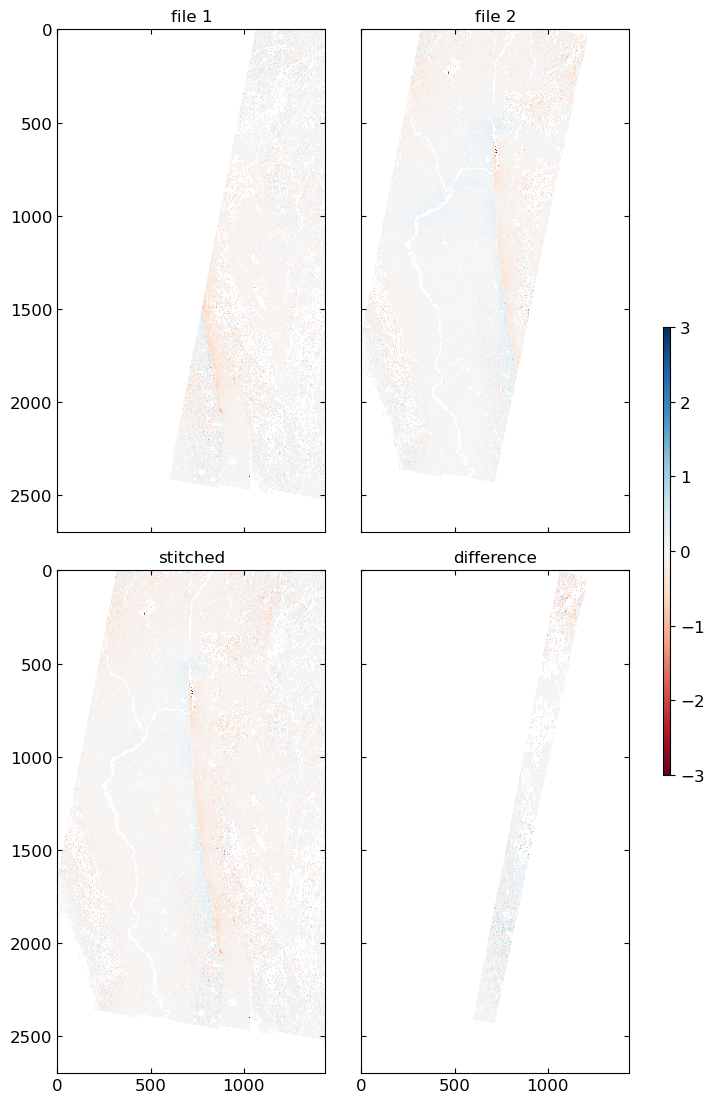

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_RG/offRgStd.geo', '/home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_RG/offRgStd.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_RG/offRgStd.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_RG/offRgStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
create output metadata and matrix in shape of (2700, 1440)
update LENGTH/WIDTH: 2700/1440
update Y/X_FIRST: 24.0/94.0
update REF_Y/X: 1080/1080
##################################################
writ

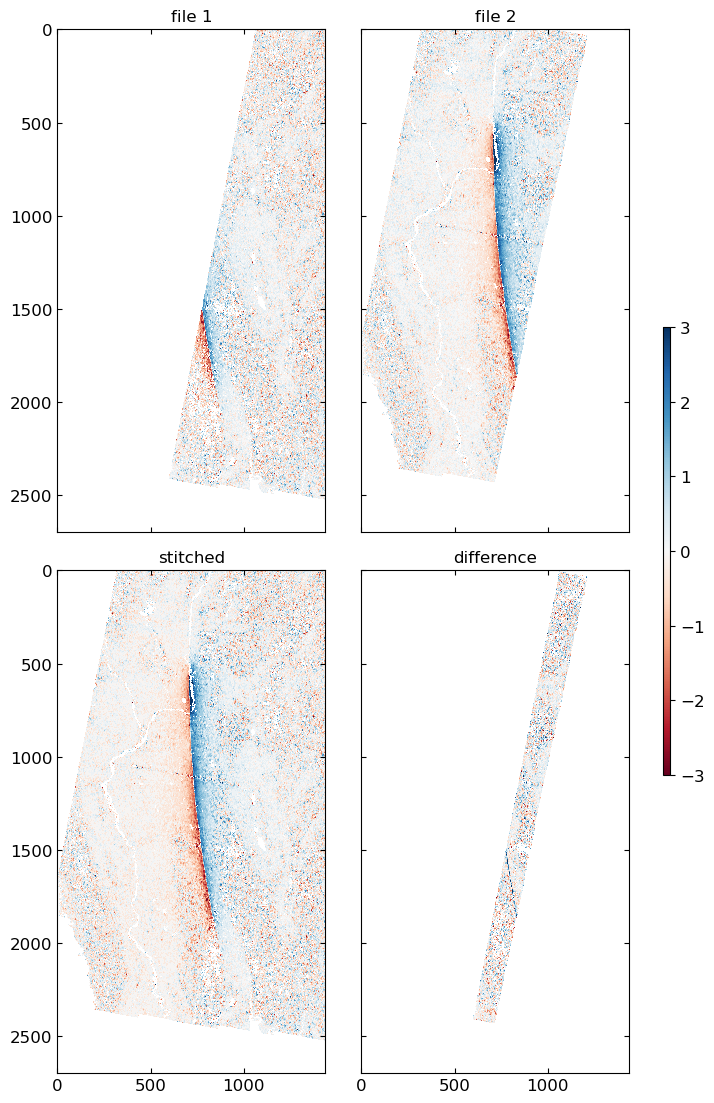

files to be stitched: ['/home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_AZ/offAzStd.geo', '/home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_AZ/offAzStd.geo']
datasets to be stitched: ['band1']
##################################################
read band1 from file: /home/eedy/penguin/25EQ_myanmar/s1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_AZ/offAzStd.geo
------------------------------
read data from file: /home/eedy/penguin/25EQ_myanmar/s1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_AZ/offAzStd.geo
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlapping area
create output metadata and matrix in shape of (2700, 1440)
update LENGTH/WIDTH: 2700/1440
update Y/X_FIRST: 24.0/94.0
update REF_Y/X: 1116/1080
##################################################
writ

In [3]:
for suffix in ['RG', 'AZ']:
    dnames_in = [f's1_d033/20250319_20250331/merged/dense_big_v1/S1_D033_20250319_20250331_OFF_{suffix}',f's1_d106/20250324_20250405/merged/dense_v1/S1_D106_20250324_20250405_OFF_{suffix}']
    dname_out = f'data/s1_decs_{suffix}'
    if suffix == 'RG':
        fbases = ['offRg.geo', 'offRgStd.geo', 'enu.geo']
    else:
        fbases = ['offAz.geo', 'offAzStd.geo', 'enu.geo']
    opts = ['', '--no-offset', '--no-offset']
    for i, (fbase, opt) in enumerate(zip(fbases, opts)):
        fnames_in = [os.path.join(proj_dir, dname_in, fbase) for dname_in in dnames_in]
        fname_out = os.path.join(dname_out, fbase)
        cmd = ' '.join(x for x in fnames_in) + f' -o {fname_out} {opt} -c RdBu '
        cmd += ' -v -3 3 ' if i == 0 else ''
        image_stitch.main(cmd.split())

## 2. Read (and resize) displacement and geometry

In [4]:
# inputs
# ALL files MUST be geocoded into the same bounding box (SNWE)
# The 1st file is used as the grid size reference for the output
dis_files = [
    os.path.join(work_dir, 'data/s1_acs_AZ/offAz.geo'),
    os.path.join(work_dir, 'data/s1_acs_RG/offRg.geo'),
    os.path.join(work_dir, 'data/s1_decs_AZ/offAz.geo'),
    os.path.join(work_dir, 'data/s1_decs_RG/offRg.geo'),
]
dis_std_files = [
    os.path.join(work_dir, 'data/s1_acs_AZ/offAzStd.geo'),
    os.path.join(work_dir, 'data/s1_acs_RG/offRgStd.geo'),
    os.path.join(work_dir, 'data/s1_decs_AZ/offAzStd.geo'),
    os.path.join(work_dir, 'data/s1_decs_RG/offRgStd.geo'),
    0.15,
    0.05,
    0.15,
    0.05,
]
enu_files = [os.path.join(os.path.dirname(x), 'enu.geo') for x in dis_files]
num_file = len(dis_files)

In [5]:
atr = readfile.read_attribute(dis_files[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
# calculate reference point in y/x

dis     = np.full((num_file, length, width), np.nan, dtype=np.float32)
dis_std = np.full((num_file, length, width), np.nan, dtype=np.float32)
ve      = np.full((num_file, length, width), np.nan, dtype=np.float32)
vn      = np.full((num_file, length, width), np.nan, dtype=np.float32)
vu      = np.full((num_file, length, width), np.nan, dtype=np.float32)

for i, (dis_file, dis_std_file, enu_file) in enumerate(zip(dis_files, dis_std_files, enu_files)):
    # read displacement
    print(f'read data from file {i+1}: {dis_file}')
    dis_i, atr_i = readfile.read(dis_file)
    # convert phase to range
    if dis_file.endswith('.unw'):
        phase2range = float(atr_i['WAVELENGTH']) / (4.0 * np.pi)
        dis_i *= phase2range

    # read displacement std
    if isinstance(dis_std_file, str):
        dis_std_i = readfile.read(dis_std_file)[0]
    else:
        dis_std_i = np.ones(dis_i.shape, dtype=np.float32) * dis_std_file

    # read unit vector
    ve_i = readfile.read(enu_file, datasetName='band1')[0]
    vn_i = readfile.read(enu_file, datasetName='band2')[0]
    vu_i = readfile.read(enu_file, datasetName='band3')[0]

    # spatial referencing
    coord = ut.coordinate(atr_i)
    ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
    print(f'\tspatial referencing to (lat, lon) = ({ref_lat}, {ref_lon}), (y, x) = ({ref_y}, {ref_x})')
    if np.isnan(dis_i[ref_y, ref_x]):
        raise ValueError('reference point is in masked out region! Choose a different one!')
    dis_i -= dis_i[ref_y, ref_x]

    # resize
    if dis_i.shape != (length, width):
        print(f'\tresizing shape from {dis_i.shape} to {(length,width)}')
        kwargs = dict(output_shape=(length, width), order=0, mode='constant', anti_aliasing=False, preserve_range=True)
        #kwargs = dict(output_shape=(length, width), order=1, mode='constant', anti_aliasing=True, preserve_range=True)
        dis_i     = resize(np.array(dis_i),     **kwargs)
        dis_std_i = resize(np.array(dis_std_i), **kwargs)
        ve_i      = resize(np.array(ve_i),      **kwargs)
        vn_i      = resize(np.array(vn_i),      **kwargs)
        vu_i      = resize(np.array(vu_i),      **kwargs)

    dis[i] = dis_i
    dis_std[i] = dis_std_i
    ve[i] = ve_i
    vn[i] = vn_i
    vu[i] = vu_i
print('finished reading data.')

read data from file 1: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/data/s1_acs_AZ/offAz.geo
	spatial referencing to (lat, lon) = (20, 94.6), (y, x) = (1440, 216)
read data from file 2: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/data/s1_acs_RG/offRg.geo
	spatial referencing to (lat, lon) = (20, 94.6), (y, x) = (1440, 216)
read data from file 3: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/data/s1_decs_AZ/offAz.geo
	spatial referencing to (lat, lon) = (20, 94.6), (y, x) = (1440, 216)
read data from file 4: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/data/s1_decs_RG/offRg.geo
	spatial referencing to (lat, lon) = (20, 94.6), (y, x) = (1440, 216)
finished reading data.


save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/pic/dis_los.png


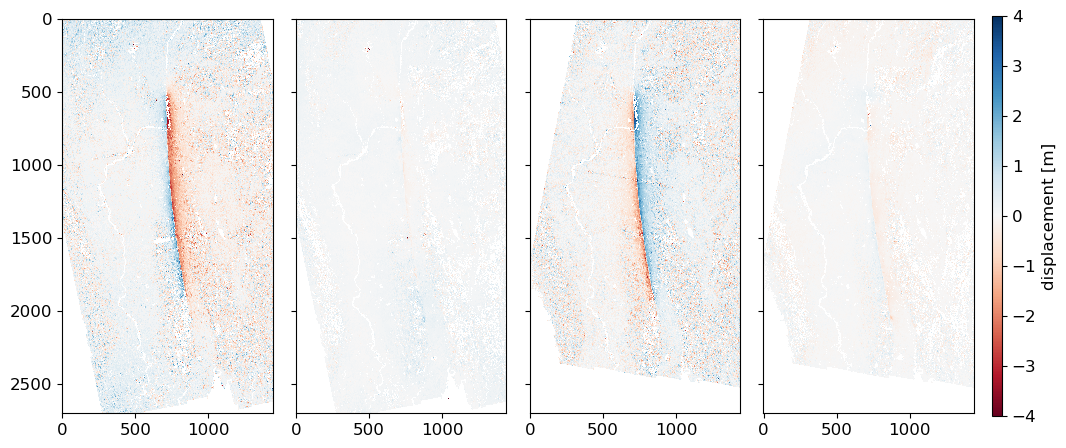

In [6]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 20], sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    im = ax.imshow(dis[i], vmin=-4, vmax=4, cmap='RdBu', interpolation='nearest')
    #im = ax.imshow(dis_std_mat[i,:], vmin=0, vmax=1.0, cmap='RdBu_r', interpolation='nearest')
fig.tight_layout()

# axis format
cax = fig.add_axes([1.0, 0.4, 0.01, 0.2])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('displacement [m]')

out_fig = os.path.join(work_dir, f'pic/dis_los.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## 3. Estimate 3D displacement field

### 3.1 Estimate 3D displacement

In [7]:
def estimate_enu_displacement(dis_los, dis_los_std, G, weight=False):

    dis_los = dis_los.reshape(G.shape[0], -1)
    dis_los_std = dis_los_std.reshape(G.shape[0], -1)

    # initial output value
    dis_enu     = np.full(3, np.nan, dtype=np.float32)
    dis_enu_std = np.full(3, np.nan, dtype=np.float32)

    # skip pixels with none in all files
    if np.all(np.isnan(dis_los)):
        return dis_enu, dis_enu_std

    # skip invalid observations in some files
    dis_los, [G, dis_los_std] = skip_invalid_obs(dis_los, mat_list=[G, dis_los_std])

    # invert
    if weight:
        w_sqrt = 1. / dis_los_std
        X, e2 = linalg.lstsq(np.multiply(G, w_sqrt), np.multiply(dis_los, w_sqrt), cond=1e-5)[:2]
    else:
        X, e2 = linalg.lstsq(G, dis_los, cond=1e-5)[:2]

    if e2.size != 0:
        dis_enu = X.flatten()

        # calculate inversion quality
        Gplus = linalg.pinv(G)
        dis_los_cov = np.diag(np.square(dis_los_std.flatten()))
        dis_enu_cov = np.linalg.multi_dot([Gplus, dis_los_cov, Gplus.T])
        dis_enu_std = np.sqrt(np.diag(dis_enu_cov))

    return dis_enu, dis_enu_std

In [8]:
# calculate the weight matrix
weight = True

# pixel-wise inversion with invalid pixels skipped.
dis_enu = np.zeros((3, length, width), dtype=np.float32) * np.nan
dis_enu_std = np.zeros((3, length, width), dtype=np.float32) * np.nan
num_pix = length * width
prog_bar = ptime.progressBar(maxValue=num_pix)
for i in range(num_pix):
    prog_bar.update(i+1, every=1000, suffix=f'{i+1} / {num_pix}')
    y, x = i // width, i % width

    # prepare inputs
    dis_los = dis[:, y, x]
    dis_los_std = dis_std[:, y, x]
    G = np.zeros((num_file, 3), dtype=np.float32)
    G[:, 0] = ve[:, y, x]
    G[:, 1] = vn[:, y, x]
    G[:, 2] = vu[:, y, x]

    dis_enu_i, dis_enu_std_i = estimate_enu_displacement(dis_los, dis_los_std, G, weight=weight)
    dis_enu[:, y, x] = dis_enu_i.flatten()
    dis_enu_std[:, y, x] = dis_enu_std_i.flatten()
prog_bar.close()

[==================================================] 3888000 / 3888000  469s /     9s 


### 3.2 Write result to HDF5 file

In [9]:
## mask
# 1. mask out pixels with large STD
# 2. mask out pixels with abnormal values
max_std_list = [0.5, 1.5, 0.5]
max_dis_list = [8, 10, 8]
print(f'mask out pixels with large STD: east > {max_std_list[0]} m, north > {max_std_list[1]} m, up > {max_std_list[2]} m.')
print(f'mask out pixels with large val: east > {max_dis_list[0]} m, north > {max_dis_list[1]} m, up > {max_dis_list[2]} m.')
for i, (max_std, max_dis) in enumerate(zip(max_std_list, max_dis_list)):
    dis_enu[i][dis_enu_std[i] > max_std] = np.nan
    dis_enu[i][dis_enu[i] > max_dis] = np.nan
# 3. mask out sparse pixels in the far field (for a clean picture)
# the maskAOI.h5 is generated using generate_mask.py --roipoly option
mask_aoi_file = os.path.join(work_dir, 'defo3d/maskAOI.h5')
if os.path.isfile(mask_aoi_file):
    print(f'mask out pixels marked in file: {mask_aoi_file}')
    mask_aoi = readfile.read(mask_aoi_file)[0]
    for i in range(3):
        dis_enu[i][mask_aoi==1] = np.nan

## spatial reference (to a point in the far-field)
# instead of a common pixels used above for stitching purpose only
ref_lat, ref_lon =  20 ,94.6
ref_y, ref_x = ut.coordinate(atr).geo2radar(ref_lat, ref_lon)[:2]
print(f'spatial referencing to point: lat / lon = {ref_lat} / {ref_lon}, y / x = {ref_y} / {ref_x}.')
for i in range(3):
    dis_enu[i] -= dis_enu[i][ref_y, ref_x]

## write to HDF5 file
for data, fname in zip([dis_enu, dis_enu_std], [dis_enu_file, dis_enu_std_file]):
    ds_dict = {
        'east'  : data[0].reshape(length, width),
        'north' : data[1].reshape(length, width),
        'up'    : data[2].reshape(length, width),
    }
    atr['FILE_TYPE'] = 'displacement'
    atr['DATA_TYPE'] = 'float32'
    atr['UNIT'] = 'm'
    atr['BANDS'] = len(ds_dict.keys())
    atr['REF_LAT'], atr['REF_LON'] = ref_lat, ref_lon
    atr['REF_Y'], atr['REF_X'] = ref_y, ref_x
    writefile.write(ds_dict, fname, metadata=atr)

mask out pixels with large STD: east > 0.5 m, north > 1.5 m, up > 0.5 m.
mask out pixels with large val: east > 8 m, north > 10 m, up > 8 m.
spatial referencing to point: lat / lon = 20 / 94.6, y / x = 1440 / 216.
delete exsited file: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5
create HDF5 file: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5 with w mode
create dataset /east  of float32    in size of (2700, 1440)         with compression=None
create dataset /north of float32    in size of (2700, 1440)         with compression=None
create dataset /up    of float32    in size of (2700, 1440)         with compression=None
finished writing to /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5
delete exsited file: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu_std.h5
create HDF5 file: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu_std.h5 with w mode
create dataset /east  of float32    in size of (2700, 1440)         wit

### 3.3 Quality check

save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/pic/dis_enu.png


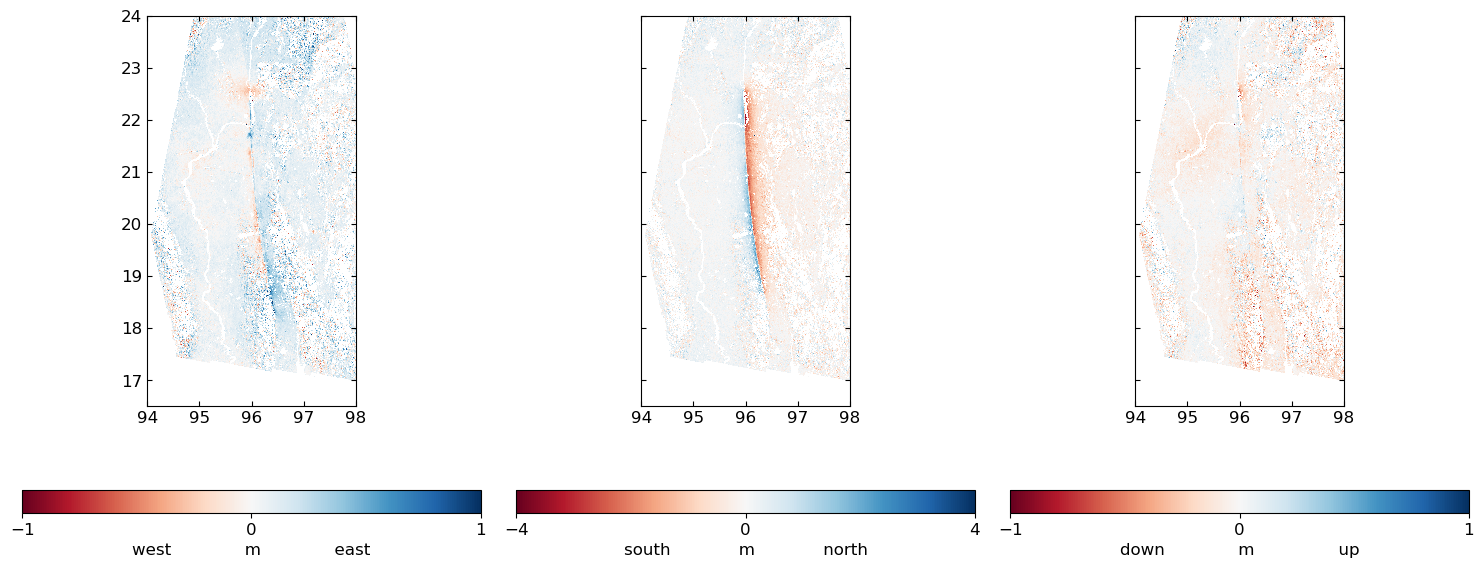

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [1, 4, 1]
im1 = axs[0].imshow(dis_enu[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(work_dir, f'pic/dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/pic/dis_enu_std.png


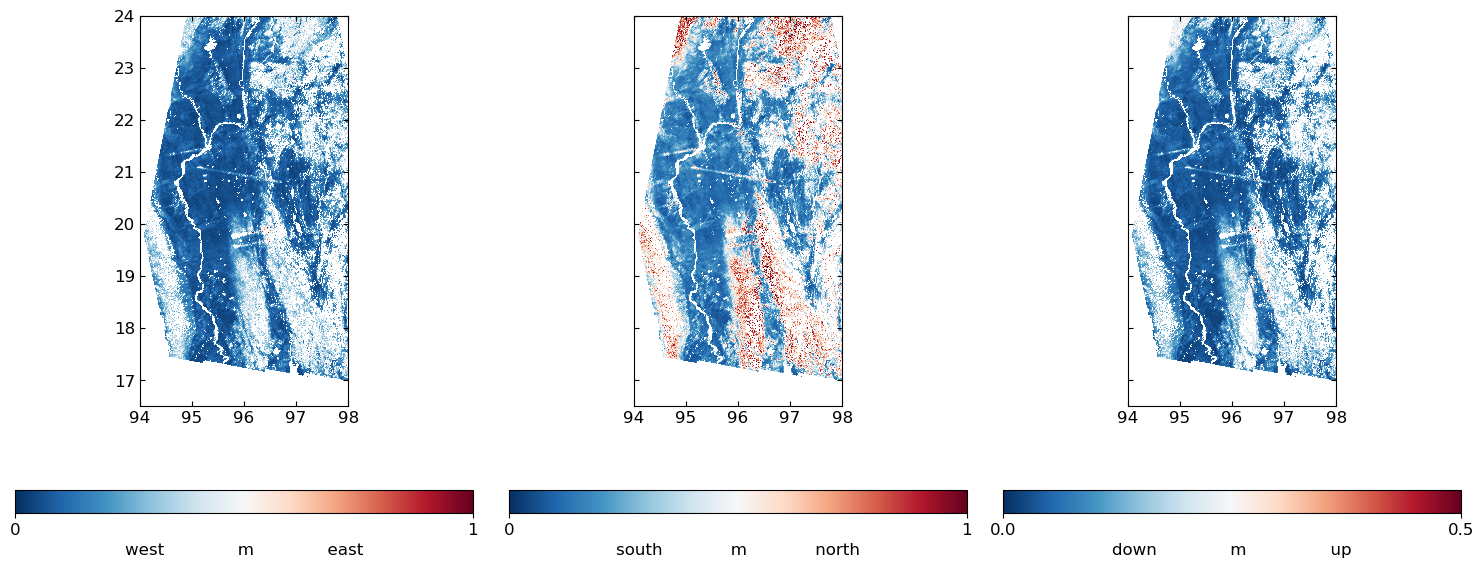

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu_r', interpolation='nearest')
vlims = [1.0, 1.0, 0.5]
im1 = axs[0].imshow(dis_enu_std[0,:].reshape(length, width), vmin=0, vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu_std[1,:].reshape(length, width), vmin=0, vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu_std[2,:].reshape(length, width), vmin=0, vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(work_dir, f'pic/dis_enu_std.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

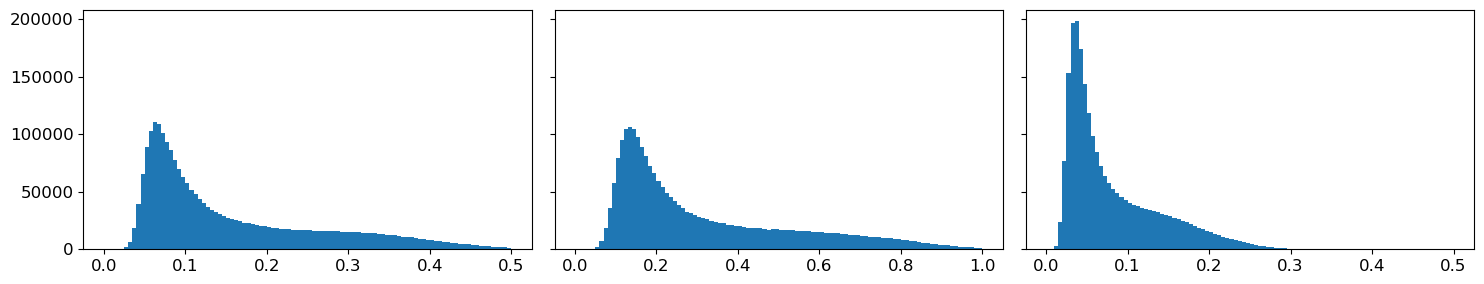

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 3], sharey=True)
for i, (ax, vmax) in enumerate(zip(axs, [0.5, 1.0, 0.5])):
    ax.hist(dis_enu_std[i].flatten(), bins=100, range=[0, vmax])
fig.tight_layout()
plt.show()

save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/pic/dis_enu.png


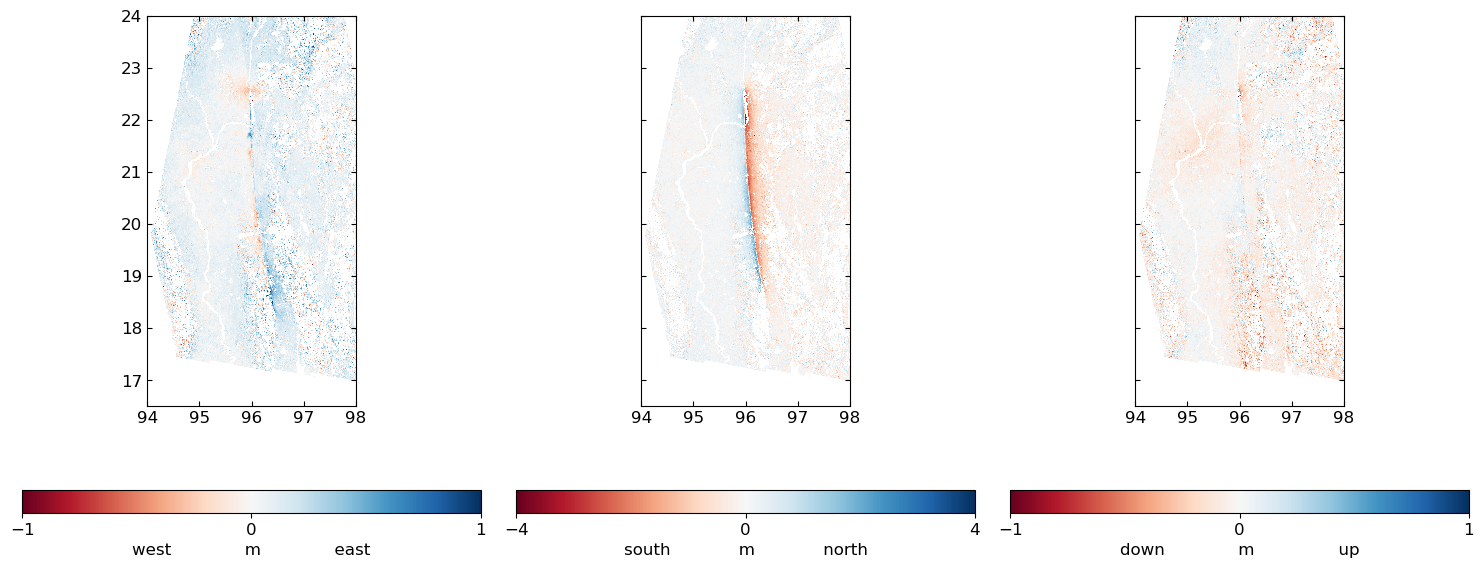

In [13]:
# mask
dis_enu_msk = np.array(dis_enu, dtype=np.float32)
max_std_list = [0.4, 0.8, 0.3]
for i, max_std in enumerate(max_std_list):
    dis_enu_msk[i][dis_enu_std[i] > max_std] = np.nan

# plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 6], sharex=True, sharey=True)
kwargs = dict(extent=(W, E, S, N), cmap='RdBu', interpolation='nearest')
vlims = [1, 4, 1]
im1 = axs[0].imshow(dis_enu_msk[0,:].reshape(length, width), vmin=-vlims[0], vmax=vlims[0], **kwargs)
im2 = axs[1].imshow(dis_enu_msk[1,:].reshape(length, width), vmin=-vlims[1], vmax=vlims[1], **kwargs)
im3 = axs[2].imshow(dis_enu_msk[2,:].reshape(length, width), vmin=-vlims[2], vmax=vlims[2], **kwargs)
ims = [im1, im2, im3]
labels = ['west              m              east',
          'south             m             north',
          'down              m                up']
for i, (ax, im, label, vlim) in enumerate(zip(axs, ims, labels, vlims)):
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[-vlim, 0, vlim])
    cbar.set_label(label)
fig.tight_layout()
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)

# output
out_fig = os.path.join(work_dir, f'pic/dis_enu.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3.4 Save to GeoTIFF file

In [14]:
atr = readfile.read_attribute('./defo3d/dis_enu.h5')
atr['BANDS'] = '1'
atr['UNIT'] = 'meters'
for ds_name in ['east', 'north', 'up']:
    out_file = f'./defo3d/dis_{ds_name[0]}.tiff'
    save_gdal.main(f'./defo3d/dis_enu.h5 -d {ds_name} -o {out_file}'.split())
    writefile.write_roipac_rsc(atr, out_file+'.rsc')

read east from file: ./defo3d/dis_enu.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 2700, 1440
  raster data type: 6 (float32)
set transform info: (94.0, 0.00277778, 0, 24.0, 0, -0.00277778)
set projection as: EPSG 4326
write data to raster band
finished writing to /penguin/eedy/25EQ_myanmar/s1_3D_result/defo3d/dis_e.tiff
read north from file: ./defo3d/dis_enu.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 2700, 1440
  raster data type: 6 (float32)
set transform info: (94.0, 0.00277778, 0, 24.0, 0, -0.00277778)
set projection as: EPSG 4326
write data to raster band
finished writing to /penguin/eedy/25EQ_myanmar/s1_3D_result/defo3d/dis_n.tiff
read up from file: ./defo3d/dis_enu.h5
initiate GDAL driver: GeoTIFF
create raster band:
  raster row / column number: 2700, 1440
  raster data type: 6 (float32)
set transform info: (94.0, 0.00277778, 0, 24.0, 0, -0.00277778)
set projection as: EPSG 4326
write data to raster b

/home/eedy/tools/MintPy/src/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)


## 4. Plot

### 4.1 ENU

In [15]:
%matplotlib widget

--------------------------------------------------1/3
view.py /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5 east --dem /home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem --dem-nocontour --shade-exag 0.05 --faultline /home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat -c RdBu -v -0.5 0.5 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar --sub-lat 16.5 24 --sub-lon 94 98 --scalebar 0.2 0.3 0.05 --ref-size 4
initiate cartopy map projection: PlateCarree
save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/pic/dis_east.png
--------------------------------------------------2/3
view.py /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5 north --dem /home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem --dem-nocontour --shade-exag 0.05 --faultline /home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat -c RdBu -v -3 3 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --f

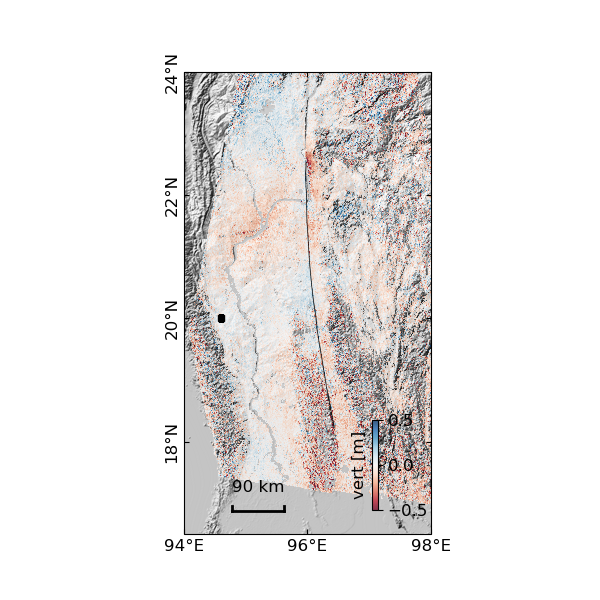

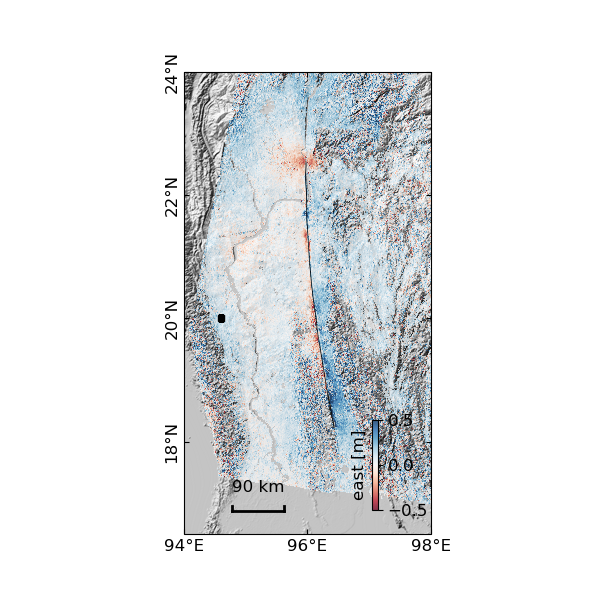

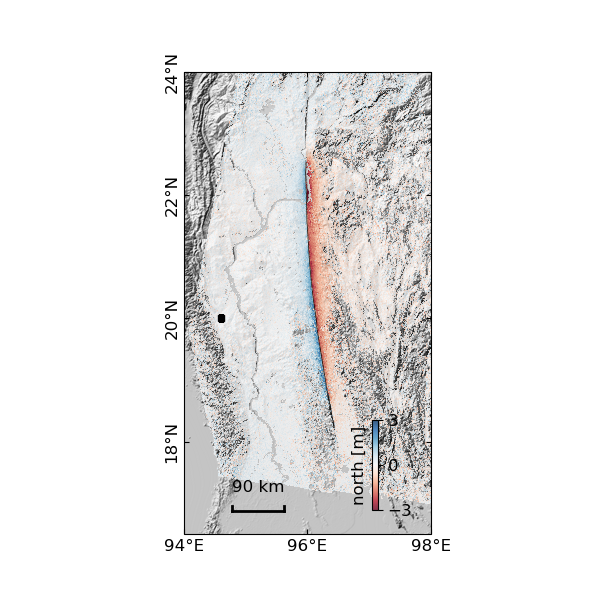

In [22]:
enu_file = os.path.join(work_dir, 'defo3d/dis_enu.h5')
dem_file = os.path.join(proj_dir, 'DEM/elevation_mli.dem')
flt_file = os.path.join(proj_dir, 'simple_rupture_trace.lonlat')

dnames = ['east', 'north', 'up']
titles = ['east', 'north', 'vert']
vmaxs = [0.5, 3, 0.5]
for i, (dname, vmax, title) in enumerate(zip(dnames, vmaxs, titles)):
    print('-'*50 + f'{i+1}/{len(dnames)}')
    out_fig = os.path.join(work_dir, f'defo3d/pic/dis_{dname}.png')

    # compose view.py cmd
    cmd = f'view.py {dis_enu_file} {dname} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
    cmd += f'-c RdBu -v -{vmax} {vmax} -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar '
    cmd += f' --sub-lat {S} {N} --sub-lon {W} {E} --scalebar 0.2 0.3 0.05 --ref-size 4 '
    #cmd += f'-o {out_file} '
    #view.main(cmd.split())
    data, atr, inps = prep_slice(cmd)

    fig, ax = plt.subplots(figsize=[6, 6], subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax, inps, im, cbar = plot_slice(ax, data, atr, inps)
    # axis format
    cax = fig.add_axes([0.62, 0.15, 0.01, 0.15])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[-vmax, 0, vmax])
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.set_ylabel(f'{title} [m]', fontsize=12)

    # output
    print('save figure to file', out_fig)
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### 4.2 Horizontal

In [29]:
enu_file = os.path.join(work_dir, 'defo3d/dis_enu.h5')
hz_file  = os.path.join(work_dir, 'defo3d/dis_hz.h5')
dem_file = os.path.join(proj_dir, 'DEM/elevation_mli.dem')
flt_file = os.path.join(proj_dir, 'simple_rupture_trace.lonlat')
# write horizontal displacement
if not os.path.exists(hz_file):
    dis_e, atr = readfile.read(enu_file, datasetName='east')
    dis_n, atr = readfile.read(enu_file, datasetName='north')
    dis_hz = (dis_e**2 + dis_n**2)**0.5
    atr['FILE_TYPE'] = 'displacement'
    writefile.write(dis_hz, out_file=hz_file, metadata=atr)
else:
    print(f'{hz_file} file exists, read it directly.')

# prep displacement east / north / horizontal
atr = readfile.read_attribute(hz_file)
lats, lons = ut.get_lat_lon(atr, box=inps.pix_box, dimension=1)
dis_e = readfile.read(enu_file, datasetName='east',  box=inps.pix_box)[0]
dis_n = readfile.read(enu_file, datasetName='north', box=inps.pix_box)[0]
dis_hz = readfile.read(hz_file, box=inps.pix_box)[0]

create HDF5 file: /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_hz.h5 with w mode
create dataset /displacement of float32    in size of (2700, 1440)         with compression=None
finished writing to /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_hz.h5


view.py /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_hz.h5 --dem /home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem --dem-nocontour --shade-exag 0.05 --faultline /home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat -c Reds -v 0 5 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar --sub-lat 16.5 24 --sub-lon 94 98 --scalebar 0.2 0.3 0.05 --ref-size 4
initiate cartopy map projection: PlateCarree
save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/pic/dis_hz.png


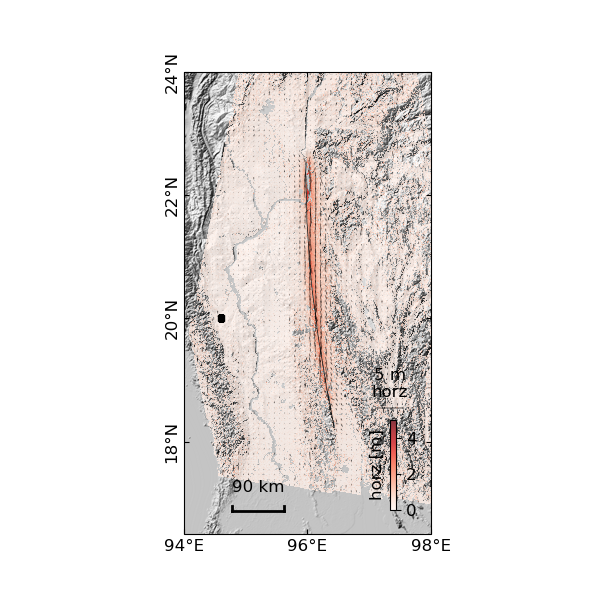

In [30]:
# prep displacement up
cmd = f'view.py {hz_file} --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f' -c Reds -v 0 5 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar '
cmd += f' --sub-lat {S} {N} --sub-lon {W} {E} --scalebar 0.2 0.3 0.05 '
cmd += f' --ref-size 4 '
dis_u, atr, inps = prep_slice(cmd)

# plot horizontal displacement
fig, ax = plt.subplots(figsize=[6, 6], subplot_kw=dict(projection=ccrs.PlateCarree()))
ax, inps, im, cbar = plot_slice(ax, dis_hz, atr, inps)

# plot horizontal displacement orientation
step = 30
Q = ax.quiver(lons[int(step/2)::step], lats[int(step/2)::step],
              dis_e[int(step/2)::step, int(step/2)::step],
              dis_n[int(step/2)::step, int(step/2)::step],
              headwidth=2., alpha=0.7)

# axis format
cax = fig.add_axes([0.65, 0.15, 0.01, 0.15])
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[0, 2, 4, 6])
cbar.ax.yaxis.set_label_position('left')
cbar.ax.set_ylabel('horz [m]', fontsize=12)
ax.quiverkey(Q, X=0.65, Y=0.32, U=5, label='5 m\nhorz', labelsep=0.08, coordinates='figure', alpha=1, linewidth=15)

# output
out_fig = os.path.join(work_dir, 'defo3d/pic/dis_hz.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

### [Backup] 4.3 3D

view.py /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/dis_enu.h5 up --dem /home/eedy/penguin/25EQ_myanmar/DEM/elevation_mli.dem --dem-nocontour --shade-exag 0.05 --faultline /home/eedy/penguin/25EQ_myanmar/simple_rupture_trace.lonlat -c RdBu -v -1 1 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar --sub-lat 16.5 24 --sub-lon 94 98 --scalebar 0.2 0.3 0.05 --ref-size 4
initiate cartopy map projection: PlateCarree
save figure to file /home/eedy/penguin/25EQ_myanmar/s1_3D_result/defo3d/pic/dis_3d.png


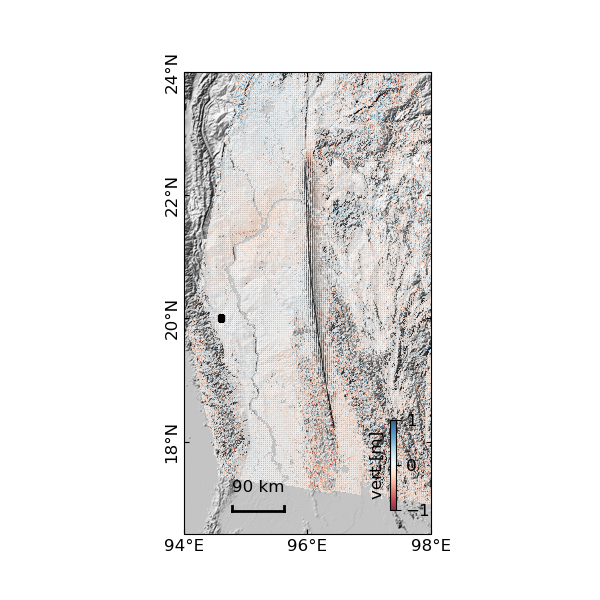

In [19]:

# prep displacement up
cmd = f'view.py {enu_file} up --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f' -c RdBu -v -1 1 -u m --lalo-label --lalo-step 2 --ylabel-rot 90 --noverbose --notitle --fontsize 12 --nocbar '
cmd += f' --sub-lat {S} {N} --sub-lon {W} {E} --scalebar 0.2 0.3 0.05 '
cmd += f' --ref-size 4 '
dis_u, atr, inps = prep_slice(cmd)

## plot
fig, ax = plt.subplots(figsize=[6, 6], subplot_kw=dict(projection=ccrs.PlateCarree()))
ax, inps, im, cbar = plot_slice(ax, dis_u, atr, inps)

# plot horz displacement
step = 12
Q = ax.quiver(
    lons[int(step/2)::step], lats[int(step/2)::step],
    dis_e[int(step/2)::step, int(step/2)::step],
    dis_n[int(step/2)::step, int(step/2)::step],
    headwidth=2, alpha=0.7)

# axis format
cax = fig.add_axes([0.65, 0.15, 0.01, 0.15])
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[-1, 0, 1])
cbar.ax.yaxis.set_label_position('left')
cbar.ax.set_ylabel('vert [m]', fontsize=12)
#ax.quiverkey(Q, X=0.54, Y=0.17, U=2, label='horz = 2 m', labelsep=0.08, coordinates='figure')

# output
out_fig = os.path.join(work_dir, 'defo3d/pic/dis_3d.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()